# Import Packages

In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Train on Small Data Set

## Import and aggregate data

In [88]:
# Import data
submission = pd.read_csv(f'{utils.get_m5_root_dir()}/data/input/sample_submission.csv')
df_raw = pd.read_csv(f'{utils.get_m5_root_dir()}/data/preprocessed/tx2_hobbies_1year.csv')

In [89]:
# drop validation data since we don't need it here
df_raw = df_raw.loc[df_raw['data_type']=='train']

In [90]:
# aggregate
df_aggregated = pd.pivot_table(df_raw, values='sale', index=['date'], aggfunc=np.sum)
df_aggregated.reset_index(level=df_aggregated.index.names, inplace=True)

In [91]:
df_aggregated

,date,sale
0,2015-04-24,379.0
1,2015-04-25,477.0
2,2015-04-26,403.0
3,2015-04-27,313.0
4,2015-04-28,301.0
...,...,...
362,2016-04-20,373.0
363,2016-04-21,340.0
364,2016-04-22,388.0
365,2016-04-23,436.0


## Plot Series

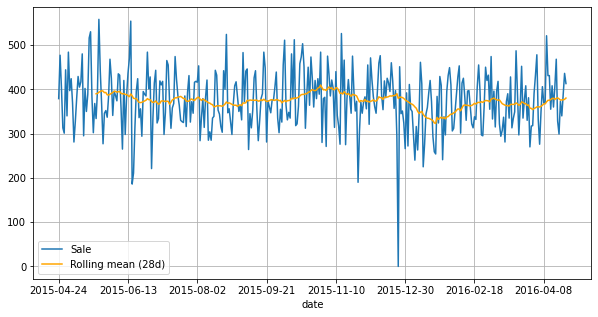

In [6]:
ax = df_aggregated.plot(x='date',
             y='sale',
             style='-',
             figsize=(10,5)
            )
roll_mean = df_aggregated['sale'].rolling(28).mean()
roll_mean.plot(ax=ax, color='orange', legend=False, grid=True)
ax.legend(['Sale', 'Rolling mean (28d)'])

## Compute Forecast on Store and Category Level

In [92]:
df_prophet = pd.DataFrame({
    'ds': df_aggregated['date'],
    'y': df_aggregated['sale']
})
df_prophet

,ds,y
0,2015-04-24,379.0
1,2015-04-25,477.0
2,2015-04-26,403.0
3,2015-04-27,313.0
4,2015-04-28,301.0
...,...,...
362,2016-04-20,373.0
363,2016-04-21,340.0
364,2016-04-22,388.0
365,2016-04-23,436.0


In [98]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True) 
model.fit(df_prophet)

In [96]:
future = model.make_future_dataframe(periods=28, include_history=False)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,2016-04-25,368.999082,297.489071,438.577288
1,2016-04-26,316.415588,242.785500,386.233979
2,2016-04-27,342.878576,271.355832,412.885390
3,2016-04-28,344.569931,272.750526,416.497061
4,2016-04-29,366.872589,292.341927,446.467955


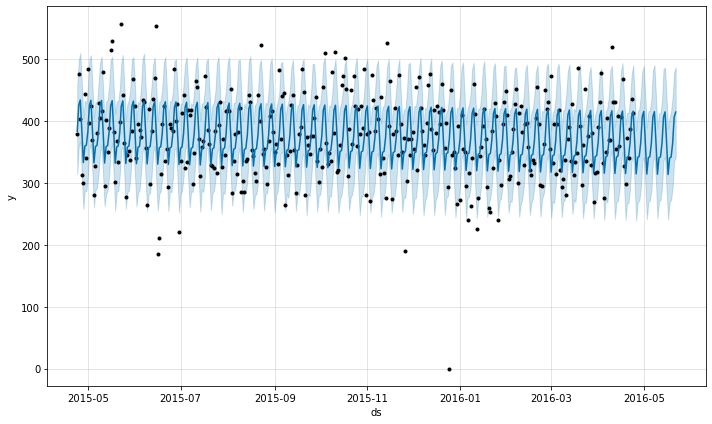

In [10]:
# visualize predictions (including history)
future_incl_hist = model.make_future_dataframe(periods=28, include_history=True)
predictions_incl_hist = model.predict(future_incl_hist)
fig = model.plot(predictions_incl_hist)

## Compute Distribution

In [11]:
# Create subset containing only relevant columns and compute a rolling mean
df_item_level = df_raw[['id','date','sale']]
df_item_level['roll_mean_28'] = df_item_level['sale'].rolling(28).mean()
df_item_level = df_item_level.reset_index(drop=True)
df_item_level


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,date,sale,roll_mean_28
0,HOBBIES_1_001_TX_2_validation,2015-04-24,0.0,NaN
1,HOBBIES_1_002_TX_2_validation,2015-04-24,1.0,NaN
2,HOBBIES_1_003_TX_2_validation,2015-04-24,0.0,NaN
3,HOBBIES_1_004_TX_2_validation,2015-04-24,0.0,NaN
4,HOBBIES_1_005_TX_2_validation,2015-04-24,0.0,NaN
...,...,...,...,...
207350,HOBBIES_2_145_TX_2_validation,2016-04-24,0.0,0.178571
207351,HOBBIES_2_146_TX_2_validation,2016-04-24,2.0,0.250000
207352,HOBBIES_2_147_TX_2_validation,2016-04-24,0.0,0.250000
207353,HOBBIES_2_148_TX_2_validation,2016-04-24,0.0,0.250000


In [12]:
# Select only last day since distribution is computed based on mean sale over past 28 days
df_item_level = df_item_level.loc[df_item_level['date'] == df_item_level['date'].max()]
df_item_level

,id,date,sale,roll_mean_28
206790,HOBBIES_1_001_TX_2_validation,2016-04-24,0.0,0.428571
206791,HOBBIES_1_002_TX_2_validation,2016-04-24,1.0,0.464286
206792,HOBBIES_1_003_TX_2_validation,2016-04-24,0.0,0.428571
206793,HOBBIES_1_004_TX_2_validation,2016-04-24,3.0,0.535714
206794,HOBBIES_1_005_TX_2_validation,2016-04-24,0.0,0.464286
...,...,...,...,...
207350,HOBBIES_2_145_TX_2_validation,2016-04-24,0.0,0.178571
207351,HOBBIES_2_146_TX_2_validation,2016-04-24,2.0,0.250000
207352,HOBBIES_2_147_TX_2_validation,2016-04-24,0.0,0.250000
207353,HOBBIES_2_148_TX_2_validation,2016-04-24,0.0,0.250000


In [13]:
# Compare Sum of Mean with actual Sales figure 
roll_mean_sum = df_item_level['roll_mean_28'].sum()

print(roll_mean_sum)                      # Sum of rolling mean at last training day
print(df_aggregated['sale'].values[-1])   # Aggregated Sum of last training day

415.35714285714283
413.0


In [14]:
# Downpropagate aggregated forecast to item level
for i,row in forecast.iterrows():        
    df_item_level[f'F{i+1}'] = df_item_level['roll_mean_28'] / roll_mean_sum * row['yhat']

df_item_level

c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,date,sale,roll_mean_28,F1,F2,F3,F4,F5,F6,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
206790,HOBBIES_1_001_TX_2_validation,2016-04-24,0.0,0.428571,0.379308,0.325046,0.352357,0.354105,0.377089,0.420748,...,0.376388,0.420048,0.428481,0.378257,0.323995,0.351306,0.353054,0.376038,0.419697,0.428130
206791,HOBBIES_1_002_TX_2_validation,2016-04-24,1.0,0.464286,0.410917,0.352133,0.381720,0.383614,0.408513,0.455811,...,0.407754,0.455052,0.464187,0.409778,0.350994,0.380582,0.382475,0.407374,0.454672,0.463808
206792,HOBBIES_1_003_TX_2_validation,2016-04-24,0.0,0.428571,0.379308,0.325046,0.352357,0.354105,0.377089,0.420748,...,0.376388,0.420048,0.428481,0.378257,0.323995,0.351306,0.353054,0.376038,0.419697,0.428130
206793,HOBBIES_1_004_TX_2_validation,2016-04-24,3.0,0.535714,0.474135,0.406307,0.440446,0.442631,0.471361,0.525936,...,0.470485,0.525060,0.535601,0.472821,0.404993,0.439133,0.441317,0.470047,0.524622,0.535163
206794,HOBBIES_1_005_TX_2_validation,2016-04-24,0.0,0.464286,0.410917,0.352133,0.381720,0.383614,0.408513,0.455811,...,0.407754,0.455052,0.464187,0.409778,0.350994,0.380582,0.382475,0.407374,0.454672,0.463808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207350,HOBBIES_2_145_TX_2_validation,2016-04-24,0.0,0.178571,0.158045,0.135436,0.146815,0.147544,0.157120,0.175312,...,0.156828,0.175020,0.178534,0.157607,0.134998,0.146378,0.147106,0.156682,0.174874,0.178388
207351,HOBBIES_2_146_TX_2_validation,2016-04-24,2.0,0.250000,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743
207352,HOBBIES_2_147_TX_2_validation,2016-04-24,0.0,0.250000,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743
207353,HOBBIES_2_148_TX_2_validation,2016-04-24,0.0,0.250000,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743


In [15]:
# drop irrelevant columns
df_item_level = df_item_level.drop(['date','sale','roll_mean_28'], axis=1)
df_item_level

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
206790,HOBBIES_1_001_TX_2_validation,0.379308,0.325046,0.352357,0.354105,0.377089,0.420748,0.429181,0.378958,0.324695,...,0.376388,0.420048,0.428481,0.378257,0.323995,0.351306,0.353054,0.376038,0.419697,0.428130
206791,HOBBIES_1_002_TX_2_validation,0.410917,0.352133,0.381720,0.383614,0.408513,0.455811,0.464946,0.410538,0.351753,...,0.407754,0.455052,0.464187,0.409778,0.350994,0.380582,0.382475,0.407374,0.454672,0.463808
206792,HOBBIES_1_003_TX_2_validation,0.379308,0.325046,0.352357,0.354105,0.377089,0.420748,0.429181,0.378958,0.324695,...,0.376388,0.420048,0.428481,0.378257,0.323995,0.351306,0.353054,0.376038,0.419697,0.428130
206793,HOBBIES_1_004_TX_2_validation,0.474135,0.406307,0.440446,0.442631,0.471361,0.525936,0.536477,0.473697,0.405869,...,0.470485,0.525060,0.535601,0.472821,0.404993,0.439133,0.441317,0.470047,0.524622,0.535163
206794,HOBBIES_1_005_TX_2_validation,0.410917,0.352133,0.381720,0.383614,0.408513,0.455811,0.464946,0.410538,0.351753,...,0.407754,0.455052,0.464187,0.409778,0.350994,0.380582,0.382475,0.407374,0.454672,0.463808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207350,HOBBIES_2_145_TX_2_validation,0.158045,0.135436,0.146815,0.147544,0.157120,0.175312,0.178826,0.157899,0.135290,...,0.156828,0.175020,0.178534,0.157607,0.134998,0.146378,0.147106,0.156682,0.174874,0.178388
207351,HOBBIES_2_146_TX_2_validation,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,0.250356,0.221059,0.189406,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743
207352,HOBBIES_2_147_TX_2_validation,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,0.250356,0.221059,0.189406,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743
207353,HOBBIES_2_148_TX_2_validation,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,0.250356,0.221059,0.189406,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743


In [16]:
# Initiate a dataframe with the structure of the sample submission csv
df_submission = pd.DataFrame(columns=submission.columns.to_list())
df_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28


In [17]:
# Append dataframe to the submission dataframe with which the csv is generated
df_submission = df_submission.append(df_item_level)
df_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
206790,HOBBIES_1_001_TX_2_validation,0.379308,0.325046,0.352357,0.354105,0.377089,0.420748,0.429181,0.378958,0.324695,...,0.376388,0.420048,0.428481,0.378257,0.323995,0.351306,0.353054,0.376038,0.419697,0.428130
206791,HOBBIES_1_002_TX_2_validation,0.410917,0.352133,0.381720,0.383614,0.408513,0.455811,0.464946,0.410538,0.351753,...,0.407754,0.455052,0.464187,0.409778,0.350994,0.380582,0.382475,0.407374,0.454672,0.463808
206792,HOBBIES_1_003_TX_2_validation,0.379308,0.325046,0.352357,0.354105,0.377089,0.420748,0.429181,0.378958,0.324695,...,0.376388,0.420048,0.428481,0.378257,0.323995,0.351306,0.353054,0.376038,0.419697,0.428130
206793,HOBBIES_1_004_TX_2_validation,0.474135,0.406307,0.440446,0.442631,0.471361,0.525936,0.536477,0.473697,0.405869,...,0.470485,0.525060,0.535601,0.472821,0.404993,0.439133,0.441317,0.470047,0.524622,0.535163
206794,HOBBIES_1_005_TX_2_validation,0.410917,0.352133,0.381720,0.383614,0.408513,0.455811,0.464946,0.410538,0.351753,...,0.407754,0.455052,0.464187,0.409778,0.350994,0.380582,0.382475,0.407374,0.454672,0.463808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207350,HOBBIES_2_145_TX_2_validation,0.158045,0.135436,0.146815,0.147544,0.157120,0.175312,0.178826,0.157899,0.135290,...,0.156828,0.175020,0.178534,0.157607,0.134998,0.146378,0.147106,0.156682,0.174874,0.178388
207351,HOBBIES_2_146_TX_2_validation,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,0.250356,0.221059,0.189406,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743
207352,HOBBIES_2_147_TX_2_validation,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,0.250356,0.221059,0.189406,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743
207353,HOBBIES_2_148_TX_2_validation,0.221263,0.189610,0.205542,0.206561,0.219969,0.245437,0.250356,0.221059,0.189406,...,0.219560,0.245028,0.249947,0.220650,0.188997,0.204929,0.205948,0.219355,0.244823,0.249743


# Create Forecasts for all Store and Category Level Combinations

In [133]:
# delete all variables
%reset -f

In [134]:
# import packages
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import itertools
from tqdm.notebook import tqdm


In [135]:
# Import data
submission = pd.read_csv(f'{utils.get_m5_root_dir()}/data/input/sample_submission.csv')
df_calendar, df_sales, df_prices = utils.import_m5_data(reduce_memory=True)

Mem. usage of decreased to  0.12 Mb (41.9% reduction)
Mem. usage of decreased to 95.00 Mb (78.7% reduction)
Mem. usage of decreased to 130.48 Mb (37.5% reduction)


In [136]:
# Create all Store and Category Combinations as tuples
stores = df_sales['store_id'].drop_duplicates()
categories = df_sales['cat_id'].drop_duplicates()
combinations = pd.Series(itertools.product(stores, categories)).values.tolist()

combinations

[('CA_1', 'HOBBIES'),
 ('CA_1', 'HOUSEHOLD'),
 ('CA_1', 'FOODS'),
 ('CA_2', 'HOBBIES'),
 ('CA_2', 'HOUSEHOLD'),
 ('CA_2', 'FOODS'),
 ('CA_3', 'HOBBIES'),
 ('CA_3', 'HOUSEHOLD'),
 ('CA_3', 'FOODS'),
 ('CA_4', 'HOBBIES'),
 ('CA_4', 'HOUSEHOLD'),
 ('CA_4', 'FOODS'),
 ('TX_1', 'HOBBIES'),
 ('TX_1', 'HOUSEHOLD'),
 ('TX_1', 'FOODS'),
 ('TX_2', 'HOBBIES'),
 ('TX_2', 'HOUSEHOLD'),
 ('TX_2', 'FOODS'),
 ('TX_3', 'HOBBIES'),
 ('TX_3', 'HOUSEHOLD'),
 ('TX_3', 'FOODS'),
 ('WI_1', 'HOBBIES'),
 ('WI_1', 'HOUSEHOLD'),
 ('WI_1', 'FOODS'),
 ('WI_2', 'HOBBIES'),
 ('WI_2', 'HOUSEHOLD'),
 ('WI_2', 'FOODS'),
 ('WI_3', 'HOBBIES'),
 ('WI_3', 'HOUSEHOLD'),
 ('WI_3', 'FOODS')]

In [137]:
# Initiate a dataframe with the structure of the sample submission csv
df_submission = pd.DataFrame(columns=submission.columns.to_list())

In [138]:

for store, cat in tqdm(combinations):
    # Data input and transformation
    df_raw = df_sales.loc[df_sales['store_id'] == str(store)].loc[
        df_sales['cat_id'] == str(cat)]
    df_raw = utils.transform_dataframe(df_raw, df_calendar, df_prices)
    
    # Data aggregation
    df_aggregated = pd.pivot_table(df_raw, values='sale', index=['date'], aggfunc=np.sum)
    df_aggregated.reset_index(level=df_aggregated.index.names, inplace=True)
    
    # Prediction on aggregated data
    df_prophet = pd.DataFrame({
        'ds': df_aggregated['date'],
        'y': df_aggregated['sale']
        })
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(future)

    # Create subset containing only relevant columns and compute a rolling mean
    df_item_level = df_raw[['id','date','sale']]
    df_item_level['roll_mean_28'] = df_item_level['sale'].rolling(28).mean()
    df_item_level = df_item_level.reset_index(drop=True)

    # Select only last day since distribution is computed based on mean sale over past 28 days
    df_item_level = df_item_level.loc[df_item_level['date'] == df_item_level['date'].max()]

    # Compare Sum of Mean with actual Sales figure 
    roll_mean_sum = df_item_level['roll_mean_28'].sum()

    # Downpropagate aggregated forecast to item level
    for i,row in forecast.iterrows():        
        df_item_level[f'F{i+1}'] = df_item_level['roll_mean_28'] / roll_mean_sum * row['yhat']

    # drop irrelevant columns
    df_item_level = df_item_level.drop(['date','sale','roll_mean_28'], axis=1)

    # Append dataframe to the submission dataframe with which the csv is generated
    df_submission = df_submission.append(df_item_level)
    


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [139]:
# view result
df_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
1080280,HOBBIES_1_001_CA_1_validation,0.504548,0.481625,0.475219,0.475022,0.537470,0.630679,0.567795,0.496930,0.474603,...,0.533414,0.628331,0.567209,0.498154,0.477679,0.473797,0.476187,0.541270,0.637145,0.576939
1080281,HOBBIES_1_002_CA_1_validation,0.477993,0.456277,0.450207,0.450021,0.509182,0.597486,0.537911,0.470775,0.449624,...,0.505339,0.595261,0.537356,0.471935,0.452538,0.448860,0.451125,0.512782,0.603611,0.546574
1080282,HOBBIES_1_003_CA_1_validation,0.477993,0.456277,0.450207,0.450021,0.509182,0.597486,0.537911,0.470775,0.449624,...,0.505339,0.595261,0.537356,0.471935,0.452538,0.448860,0.451125,0.512782,0.603611,0.546574
1080283,HOBBIES_1_004_CA_1_validation,0.531103,0.506974,0.500230,0.500023,0.565758,0.663873,0.597679,0.523084,0.499583,...,0.561488,0.661401,0.597062,0.524372,0.502820,0.498734,0.501250,0.569758,0.670679,0.607304
1080284,HOBBIES_1_005_CA_1_validation,0.610769,0.583020,0.575265,0.575026,0.650621,0.763454,0.687331,0.601546,0.574520,...,0.645711,0.760612,0.686622,0.603028,0.578243,0.573544,0.576437,0.655221,0.771280,0.698400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748976,FOODS_3_823_WI_3_validation,1.780335,1.711025,1.660348,1.680355,1.904150,2.260053,2.168890,1.772021,1.704686,...,1.909668,2.267723,2.178504,1.783388,1.717635,1.670262,1.693333,1.919965,2.278501,2.189791
2748977,FOODS_3_824_WI_3_validation,1.780335,1.711025,1.660348,1.680355,1.904150,2.260053,2.168890,1.772021,1.704686,...,1.909668,2.267723,2.178504,1.783388,1.717635,1.670262,1.693333,1.919965,2.278501,2.189791
2748978,FOODS_3_825_WI_3_validation,1.751620,1.683427,1.633568,1.653253,1.873438,2.223601,2.133908,1.743440,1.677191,...,1.878867,2.231147,2.143367,1.754624,1.689931,1.643322,1.666021,1.888998,2.241751,2.154472
2748979,FOODS_3_826_WI_3_validation,1.780335,1.711025,1.660348,1.680355,1.904150,2.260053,2.168890,1.772021,1.704686,...,1.909668,2.267723,2.178504,1.783388,1.717635,1.670262,1.693333,1.919965,2.278501,2.189791


In [141]:
# Bring data to the required form (evaluation & validation)
df_submission = df_submission.append(
    df_submission.replace(to_replace='validation', value='evaluation', regex=True))
filename = utils.get_m5_root_dir() + '/data/submissions/fbprophet.csv'
df_submission.to_csv(filename, index=False)
df_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
1080280,HOBBIES_1_001_CA_1_validation,0.504548,0.481625,0.475219,0.475022,0.537470,0.630679,0.567795,0.496930,0.474603,...,0.533414,0.628331,0.567209,0.498154,0.477679,0.473797,0.476187,0.541270,0.637145,0.576939
1080281,HOBBIES_1_002_CA_1_validation,0.477993,0.456277,0.450207,0.450021,0.509182,0.597486,0.537911,0.470775,0.449624,...,0.505339,0.595261,0.537356,0.471935,0.452538,0.448860,0.451125,0.512782,0.603611,0.546574
1080282,HOBBIES_1_003_CA_1_validation,0.477993,0.456277,0.450207,0.450021,0.509182,0.597486,0.537911,0.470775,0.449624,...,0.505339,0.595261,0.537356,0.471935,0.452538,0.448860,0.451125,0.512782,0.603611,0.546574
1080283,HOBBIES_1_004_CA_1_validation,0.531103,0.506974,0.500230,0.500023,0.565758,0.663873,0.597679,0.523084,0.499583,...,0.561488,0.661401,0.597062,0.524372,0.502820,0.498734,0.501250,0.569758,0.670679,0.607304
1080284,HOBBIES_1_005_CA_1_validation,0.610769,0.583020,0.575265,0.575026,0.650621,0.763454,0.687331,0.601546,0.574520,...,0.645711,0.760612,0.686622,0.603028,0.578243,0.573544,0.576437,0.655221,0.771280,0.698400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748976,FOODS_3_823_WI_3_evaluation,1.780335,1.711025,1.660348,1.680355,1.904150,2.260053,2.168890,1.772021,1.704686,...,1.909668,2.267723,2.178504,1.783388,1.717635,1.670262,1.693333,1.919965,2.278501,2.189791
2748977,FOODS_3_824_WI_3_evaluation,1.780335,1.711025,1.660348,1.680355,1.904150,2.260053,2.168890,1.772021,1.704686,...,1.909668,2.267723,2.178504,1.783388,1.717635,1.670262,1.693333,1.919965,2.278501,2.189791
2748978,FOODS_3_825_WI_3_evaluation,1.751620,1.683427,1.633568,1.653253,1.873438,2.223601,2.133908,1.743440,1.677191,...,1.878867,2.231147,2.143367,1.754624,1.689931,1.643322,1.666021,1.888998,2.241751,2.154472
2748979,FOODS_3_826_WI_3_evaluation,1.780335,1.711025,1.660348,1.680355,1.904150,2.260053,2.168890,1.772021,1.704686,...,1.909668,2.267723,2.178504,1.783388,1.717635,1.670262,1.693333,1.919965,2.278501,2.189791


In [143]:
# Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
!kaggle competitions submit -c m5-forecasting-accuracy -f data/submissions/fbprophet.csv -m "fbprohphet"

Successfully submitted to M5 Forecasting - Accuracy



  0%|          | 0.00/32.5M [00:00<?, ?B/s]
  0%|          | 8.00k/32.5M [00:00<12:32, 45.2kB/s]
  1%|1         | 488k/32.5M [00:00<08:41, 64.4kB/s] 
  3%|2         | 896k/32.5M [00:00<06:02, 91.4kB/s]
  4%|3         | 1.24M/32.5M [00:00<04:13, 129kB/s]
  5%|4         | 1.59M/32.5M [00:00<03:05, 175kB/s]
  6%|6         | 2.05M/32.5M [00:00<02:09, 246kB/s]
  8%|8         | 2.71M/32.5M [00:01<01:30, 346kB/s]
 10%|9         | 3.12M/32.5M [00:01<01:04, 478kB/s]
 11%|#         | 3.52M/32.5M [00:01<00:46, 651kB/s]
 12%|#2        | 3.93M/32.5M [00:01<00:35, 854kB/s]
 14%|#3        | 4.48M/32.5M [00:01<00:25, 1.15MB/s]
 15%|#5        | 4.90M/32.5M [00:01<00:19, 1.47MB/s]
 16%|#6        | 5.32M/32.5M [00:01<00:15, 1.83MB/s]
 18%|#7        | 5.73M/32.5M [00:01<00:12, 2.20MB/s]
 19%|#8        | 6.15M/32.5M [00:01<00:10, 2.58MB/s]
 20%|##        | 6.56M/32.5M [00:02<00:09, 2.91MB/s]
 21%|##1       | 6.98M/32.5M [00:02<00:08, 3.21MB/s]
 23%|##2       | 7.38M/32.5M [00:02<00:07, 3.47MB/s]
 24%|##3 